In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import muon_data, pileup_data, muon_data_split, pileup_data_split

from nn_models import create_model, create_model_sequential

from nn_training import train_model, train_model_sequential

%matplotlib inline

2018-07-21 22:48:07,043 [INFO    ] Using cmssw CMSSW_9_3_11
2018-07-21 22:48:07,273 [INFO    ] Using numpy 1.12.1
2018-07-21 22:48:10,029 [INFO    ] Using tensorflow 1.1.0
Using TensorFlow backend.
2018-07-21 22:48:12,462 [INFO    ] Using keras 2.0.5
2018-07-21 22:48:12,798 [INFO    ] Using sklearn 0.18.1


In [2]:
# Import muon data
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.275)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) > discr_pt_cut, 1., 100.)  # mask_value is set to 100
  y_test = [y_test, labels.astype(np.float32)]

2018-07-21 22:48:13,219 [INFO    ] Loading muon data ...
2018-07-21 22:48:19,245 [INFO    ] Loaded the variables with shape (3350150, 87)
2018-07-21 22:48:19,246 [INFO    ] Loaded the parameters with shape (3350150, 3)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
nn_encode.py:86: RuntimeWarning: invalid value encountered in greater
  x_theta_tmp   = np.abs(self.x_theta) > theta_cuts
2018-07-21 22:48:30,053 [INFO    ] Loaded # of training and testing events: (2428858, 921292)


In [3]:
# Import pileup data
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, discr_pt_cut=discr_pt_cut, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.zeros((pu_x_train.shape[0],), dtype=np.float32) + 100., np.zeros((pu_x_train.shape[0],), dtype=np.float32)]  # mask_value is set to 100
  pu_y_test = [np.zeros((pu_x_test.shape[0],), dtype=np.float32) + 100., np.zeros((pu_x_test.shape[0],), dtype=np.float32)]  # mask_value is set to 100

2018-07-21 22:48:30,086 [INFO    ] Loading pileup data ...
2018-07-21 22:48:30,722 [INFO    ] Loaded the variables with shape (378768, 87)
2018-07-21 22:48:30,723 [INFO    ] Loaded the auxiliary info with shape (378768, 4)
2018-07-21 22:48:32,008 [INFO    ] Loaded # of training and testing events: (182484, 195623)


In [4]:
# Create models

model = create_model(nvariables=nvariables, lr=learning_rate, discr_loss_weight=discr_loss_weight)

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate)

In [ ]:
# Training

if False:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model_sequential(model_seq, x_train, y_train[0], 
                                   model_name='model', epochs=20, validation_split=0.1, 
                                   batch_size=256, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [ ]:
# Validation

if False:
  # Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [27]:
# Predict

from nn_models import load_my_model

loaded_model = load_my_model(name='model')

nentries_test = x_test.shape[0]//10

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test])
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale

print y_test_true.shape, y_test_true
print y_test_meas.shape, y_test_meas

2018-07-21 23:19:06,751 [INFO    ] Loaded model from model.json and weights from model_weights.h5


(92129,) [-0.13722923  0.14607441 -0.08230478 ...,  0.05119965 -0.10738268
  0.33946854]
(92129,) [-0.13853464  0.14387017 -0.09065869 ...,  0.06045341 -0.12697688
  0.31383362]


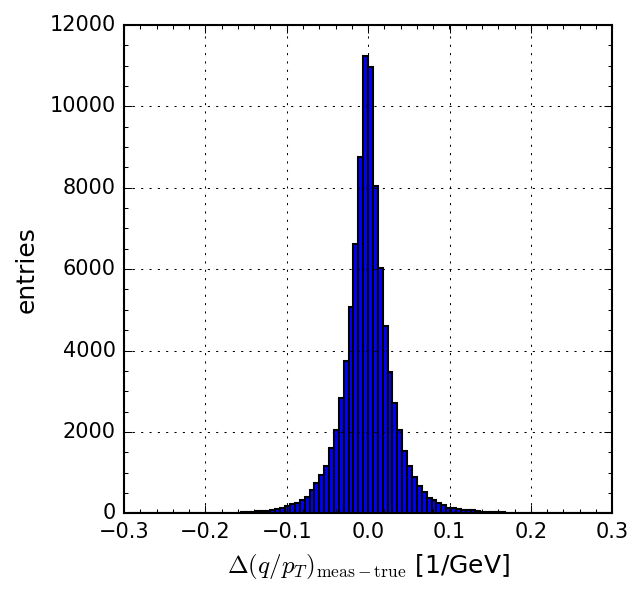

2018-07-21 23:53:50,311 [INFO    ] # of entries: 92129, mean: -0.000543148373254, std: 0.0349907390773


In [76]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)

# Plot
plt.figure()
yy = y_test_meas - y_test_true
plt.hist(yy, bins=100, range=(-0.3,0.3-eps))
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
plt.show()
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

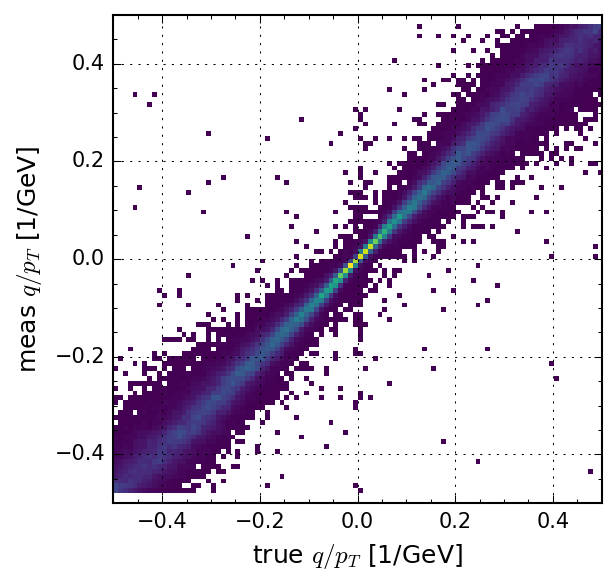

In [77]:
plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5-eps),(-0.5,0.5-eps)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]')
#plt.colorbar()
plt.show()

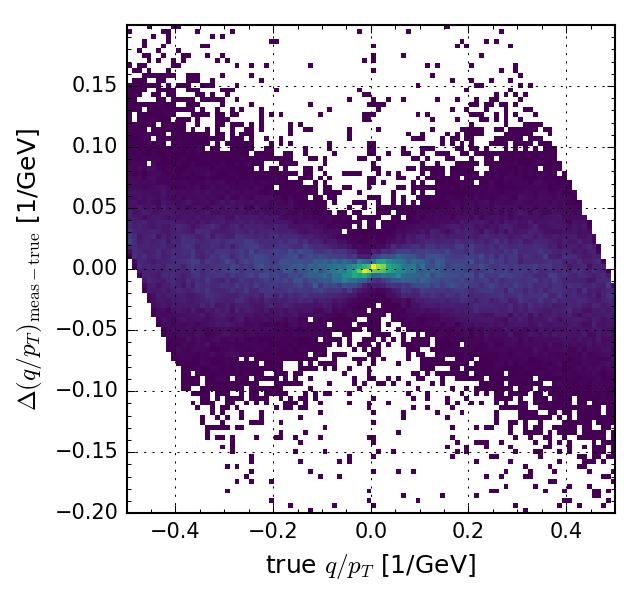

In [78]:
plt.figure()
yy = y_test_meas - y_test_true
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5-eps),(-0.2,0.2-eps)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
#plt.colorbar()
plt.show()

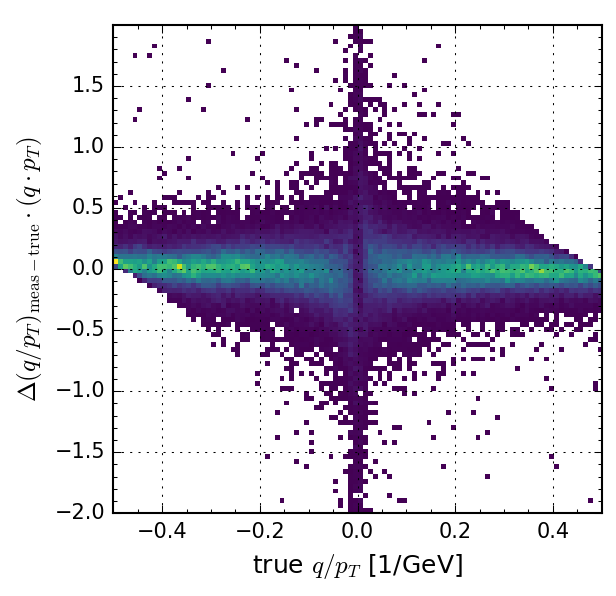

In [79]:
plt.figure()
yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5-eps),(-2,2-eps)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$')
#plt.colorbar()
plt.show()

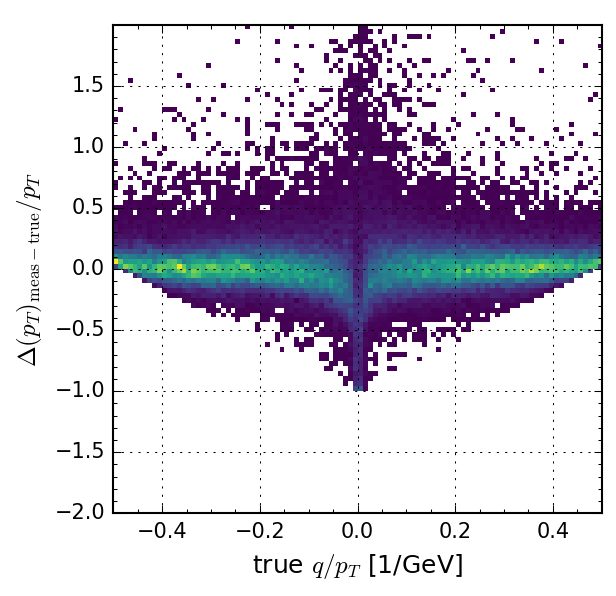

In [80]:
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5-eps),(-2,2-eps)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
#plt.colorbar()
plt.show()

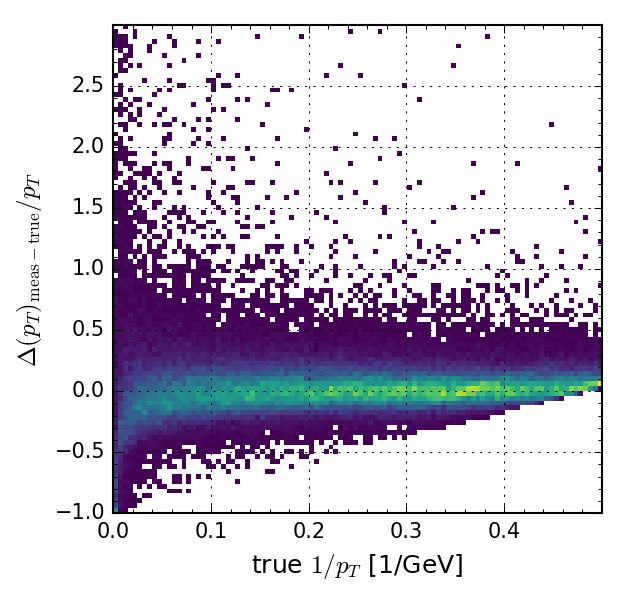

In [81]:
plt.figure()
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
plt.hist2d(xx, yy, bins=(100,100), range=((0,0.5-eps),(-1,3-eps)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $1/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
#plt.colorbar()
plt.show()

In [73]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return 0.5*a*np.exp(-np.square((x-x0)/sigma))

xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

xedges = np.linspace(0, 0.5, num=101)
inds = np.digitize(xx, xedges[1:])

nbinsx = 100
xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[yy_i < 10]
  a, mu, sig = 100, np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, bin_edges = np.histogram(yy_i, bins=300, range=(-3,3))
  xdata = (bin_edges[:-1] + bin_edges[1:])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[a,mu,sig])
  
  #print i, mu, sig, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

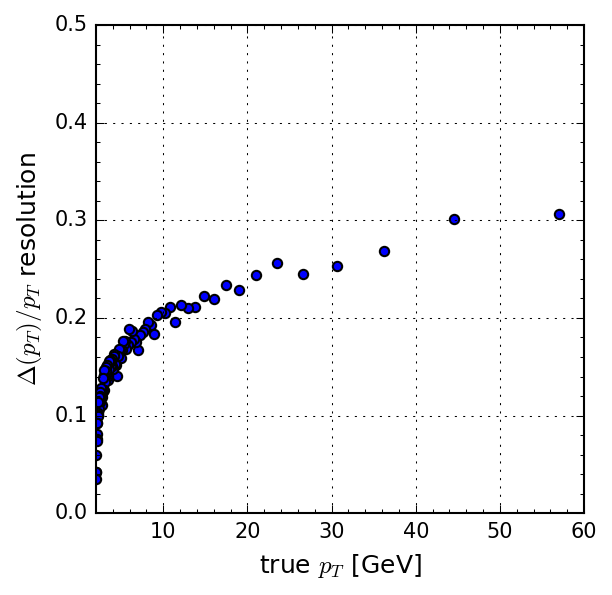

In [74]:
plt.figure()
plt.scatter(xxx, yyy)
plt.xlim(2,60)
plt.ylim(0,0.5)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution')
plt.grid(True)
plt.show()

In [15]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [16]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < 14.)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = y_train[0][valid].copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1) or lay in (11,):  # ME1/1, ME1/2, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (2,) or lay in (5,6) or lay in (9,10):  # ME2, RE1, RE2, GE1/1, GE2/1
          coef = 1.0/np.std(x_i)
        else:  # ME3, ME4, RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
    
      # x_time
      elif (nlayers*3) <= i < (nlayers*4):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ', precision=6)